In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from math import sqrt

# Read in data and prepare for recommendation system

In [2]:
df_path = '/Users/linwang/Documents/AmaRec/'
df = pd.read_csv(df_path + 'data/processed/data_clean_kmeanlabel.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 451648 entries, 0 to 451647
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   customer_id            451648 non-null  int64 
 1   review_id              451648 non-null  object
 2   product_id             451648 non-null  object
 3   review_date            451648 non-null  object
 4   star_rating            451648 non-null  int64 
 5   raw_product_title      451648 non-null  object
 6   raw_review_headline    451646 non-null  object
 7   raw_review_body        451530 non-null  object
 8   product_title          451647 non-null  object
 9   review_headline        451033 non-null  object
 10  review_body            450864 non-null  object
 11  product cluster label  451648 non-null  int64 
 12  cluster_label          451648 non-null  object
dtypes: int64(3), object(10)
memory usage: 44.8+ MB


# EDA

### Star ratings for each cluster

In [3]:
df.groupby('product cluster label')['star_rating'].describe()

,count,mean,std,min,25%,50%,75%,max
product cluster label,,,,,,,,
0,10226.0,4.310483,1.205822,1.0,4.0,5.0,5.0,5.0
1,5815.0,4.131384,1.372216,1.0,4.0,5.0,5.0,5.0
2,11572.0,4.519703,1.011152,1.0,5.0,5.0,5.0,5.0
3,311730.0,4.245241,1.236134,1.0,4.0,5.0,5.0,5.0
4,24924.0,4.296903,1.171265,1.0,4.0,5.0,5.0,5.0
5,32429.0,4.171451,1.304421,1.0,4.0,5.0,5.0,5.0
6,12799.0,4.393078,1.105521,1.0,4.0,5.0,5.0,5.0
7,24320.0,4.331414,1.190910,1.0,4.0,5.0,5.0,5.0
8,17833.0,4.272416,1.218792,1.0,4.0,5.0,5.0,5.0


### Visualize the clusters

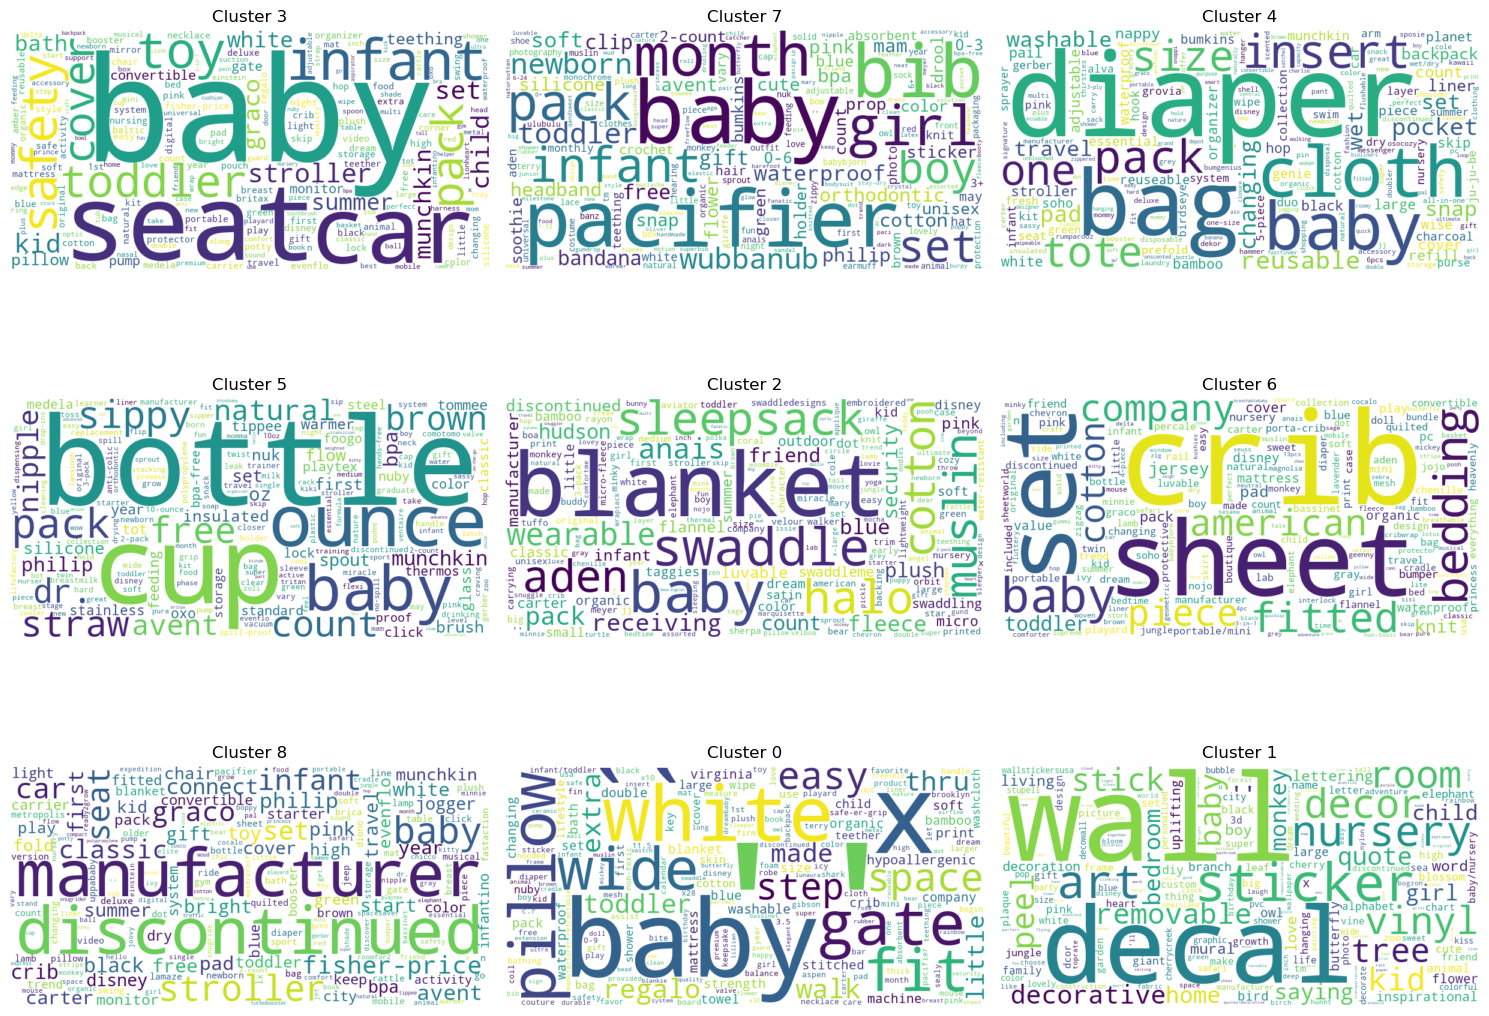

In [4]:
cluster_labels = df['product cluster label'].unique()
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 12))
axes = axes.flatten()

for i, cluster_label in enumerate(cluster_labels):
    df_text = df[df['product cluster label'] == cluster_label]['product_title']
    combined_text = ' '.join(df_text.astype(str))
    word_frequencies = Counter(combined_text.split())
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_frequencies)
    ax = axes[i]
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(f'Cluster {cluster_label}')
    ax.axis('off')

if len(cluster_labels) < len(axes):
    fig.delaxes(axes[len(cluster_labels)])

plt.tight_layout()
plt.savefig('kmeans-wordcloud.png')
plt.show()

### Remove products contain names 'discontinued'

In [6]:
df = df[~df['product_title'].astype(str).str.contains('discontinued', na=False)]

## Randomly select 1000 products from each cluster (8000 in total)

In [7]:
df_sample = df.groupby('product cluster label').sample(1000, random_state=42)
n_cust = df_sample['customer_id'].nunique()
n_prod = df_sample['product_id'].nunique()
print(f'unique number of customers: {n_cust}')
print(f'unique number of products: {n_prod}')

unique number of customers: 7774
unique number of products: 5185


## Content-based recommendation

### For new users, recommend top products (ignore cluster labels)

In [8]:
user_mean_ratings = df_sample.groupby('customer_id')['star_rating'].mean()
customer_id = '000001'
if customer_id not in (user_mean_ratings.index):
    print("New user. Providing recommendations based on highest overall star ratings.")
    # Get top-rated items across all products
    N = 5
    top_rated_items = df.groupby(['product_id', 'product_title'])['star_rating'].mean().nlargest(N).reset_index()
    for _, row in top_rated_items.iterrows():
        print("Product ID:", row['product_id'])
        print("Product Title:", row['product_title'])

New user. Providing recommendations based on highest overall star ratings.
Product ID: 0980027519
Product Title: nature lullaby first second year calendar
Product ID: 0980027594
Product Title: nature lullaby second year sticker calendar
Product ID: 1442498145
Product Title: chicka chicka abc board book rattle set
Product ID: 1495141659
Product Title: little animal lover baby first year memory book simple book first
Product ID: 1607306123
Product Title: university florida baby gift set


# Memory-based recommendation: Item-based and user-based collaborative filtering

### A toy example

In [9]:
# Build a 4 users by 3 item data array
user_item_matrix = [[5, 3, 1],
                    [5, 3, 0],
                    [5, 5, 2],
                    [4, 0, 2]]
user_item_matrix = np.array(user_item_matrix)
print(f'original matrix: \n{user_item_matrix}')

# item-based filtering: weight ratings based on item-item similarity
item_similarity = cosine_similarity(user_item_matrix.T)
pred = user_item_matrix.dot(item_similarity) / np.abs(item_similarity).sum(axis=1)
print(f'item-based prediction: \n{pred}')

# user-based filtering: weight ratings based on user-user similarity
user_similarity = cosine_similarity(user_item_matrix)
mean_user_rating = user_item_matrix.mean(axis=1)
ratings_diff = (user_item_matrix - mean_user_rating[:, np.newaxis]) 
pred = mean_user_rating[:, np.newaxis] + user_similarity.dot(ratings_diff) / np.abs(user_similarity).sum(axis=1).reshape(-1,1)
print(f'user-based prediction: \n{pred}')

original matrix: 
[[5 3 1]
 [5 3 0]
 [5 5 2]
 [4 0 2]]
item-based prediction: 
[[3.14634394 3.17197456 2.84068656]
 [2.84678848 2.91181334 2.43492675]
 [4.10133362 4.21951634 3.78272056]
 [2.09002063 1.90491645 2.11593199]]
user-based prediction: 
[[4.83147844 2.90261879 1.26590277]
 [4.50384216 2.59421153 0.90194631]
 [5.81023581 3.95883639 2.23092779]
 [3.85741285 1.69536972 0.44721742]]


### Build user-item matrix

In [10]:
df_piv = df_sample.pivot_table(index='customer_id',columns='product_id',values='star_rating',fill_value=0)
print(df_piv.shape)
user_item_matrix = df_piv.to_numpy()

(7774, 5185)


### Calculate user-user and item-item similarity matrices

In [11]:
user_similarity = cosine_similarity(user_item_matrix)
item_similarity = cosine_similarity(user_item_matrix.T)
print(user_similarity.shape)
print(item_similarity.shape)

(7774, 7774)
(5185, 5185)


### Make predictions

In [12]:
def predict(ratings, similarity, type):
    if type == 'item':
        pred = ratings.dot(similarity) / np.abs(similarity).sum(axis=1)        
    elif type == 'user':
        mean_user_rating = ratings.mean(axis=1)
        ratings_diff = (ratings - mean_user_rating[:, np.newaxis]) 
        pred = mean_user_rating[:, np.newaxis] + similarity.dot(ratings_diff) / np.abs(similarity).sum(axis=1).reshape(-1,1)
    return pred

item_prediction = predict(user_item_matrix, item_similarity, type='item')
user_prediction = predict(user_item_matrix, user_similarity, type='user')
np.array_equal(item_prediction,user_prediction) #the two methods return different results

False

### Check item-based recommendations

In [14]:
# Find the top N items for each user
N=5
top_items_indices = np.argsort(item_prediction, axis=1)[:, :-N-1:-1] #user*N
top_items_indices

array([[2185, 1739, 1721, 1722, 1723],
       [3169, 5184, 1721, 1723, 1724],
       [4767, 5184, 1721, 1723, 1724],
       ...,
       [3623, 1740, 1722, 1723, 1724],
       [ 476, 3123, 2110, 4838, 1730],
       [4560, 5184, 1722, 1724, 1725]])

#### For a specified user, show interacted vs. recommended items

In [15]:
def get_product_title(user_item_matrix, indices, type):
    """Match product index, product id and product title""" 
    recommendations = user_item_matrix.columns[indices]
    df_use = df.loc[df['product_id'].isin(recommendations), 
                    ['product_id', 'product_title', 'star_rating']]
    df_mean_star_rating = df_use.groupby(['product_id', 'product_title'])['star_rating'].mean().reset_index()
        
    if type=='recommendation':
        # Filter the products with a mean star rating higher than 3
        df_results = df_mean_star_rating[df_mean_star_rating['star_rating'] > 3]
        for _, row in df_results.iterrows():
            print("Product ID:", row['product_id'])
            print("Product Title:", row['product_title'])
            print("Predicted Rating:", row['star_rating'])
    elif type=='interaction':
        df_results = df_mean_star_rating
        for _, row in df_results.iterrows():
            print("Product ID:", row['product_id'])
            print("Product Title:", row['product_title'])
            print("Product Rating:", row['star_rating'])
    else:
        raise ValueError('Please provide type: recommendation or interaction')

In [16]:
target_user_index = 5804
user_top_items_indices = top_items_indices[target_user_index]
user_interactions = df_piv.iloc[target_user_index].values.nonzero()[0]
filtered_indices = np.setdiff1d(user_top_items_indices, user_interactions)

print('User interacted items:')
get_product_title(df_piv, user_interactions, type='interaction')
print('\n-------\n')
print('User recomended items:')
get_product_title(df_piv, filtered_indices, type='recommendation')

User interacted items:
Product ID: B00CU5M650
Product Title: aden aden anais easy swaddle blanket
Product Rating: 3.7142857142857144

-------

User recomended items:
Product ID: B0081K0RG8
Product Title: pura kiki stainless steel infant bottle orange ounce
Predicted Rating: 4.5
Product ID: B0081LCS7S
Product Title: philip avent toddler spout cup pack
Predicted Rating: 3.625
Product ID: B0081U0CVI
Product Title: carter girl one size swaddle pack blanket
Predicted Rating: 5.0
Product ID: B0081ZOV06
Product Title: philip aventbpa free soothie pacifier 3+ month green count
Predicted Rating: 4.133333333333334


### Check user-based recommendations

In [17]:
# Find the top N items for each user
top_items_indices = np.argsort(user_prediction, axis=1)[:, :-N-1:-1] #user*N
top_items_indices

array([[2185, 1739, 1721, 1722, 1723],
       [3169, 5184, 1721, 1723, 1724],
       [4767, 5184, 1721, 1723, 1724],
       ...,
       [3623, 1740, 1722, 1723, 1724],
       [ 476, 3123, 2110, 4838, 1730],
       [4560, 5184, 1722, 1724, 1725]])

#### for a specified user, show interacted vs. recommended items

In [18]:
target_user_index = 5804
user_top_items_indices = top_items_indices[target_user_index]
user_interactions = df_piv.iloc[target_user_index].values.nonzero()[0]
filtered_indices = np.setdiff1d(user_top_items_indices, user_interactions)

print('User interacted items:')
get_product_title(df_piv, user_interactions, type='interaction')
print('\n-------\n')
print('User recomended items:')
get_product_title(df_piv, filtered_indices, type='recommendation')

User interacted items:
Product ID: B00CU5M650
Product Title: aden aden anais easy swaddle blanket
Product Rating: 3.7142857142857144

-------

User recomended items:
Product ID: B0081K0RG8
Product Title: pura kiki stainless steel infant bottle orange ounce
Predicted Rating: 4.5
Product ID: B0081LCS7S
Product Title: philip avent toddler spout cup pack
Predicted Rating: 3.625
Product ID: B0081U0CVI
Product Title: carter girl one size swaddle pack blanket
Predicted Rating: 5.0
Product ID: B0081ZOV06
Product Title: philip aventbpa free soothie pacifier 3+ month green count
Predicted Rating: 4.133333333333334


## Use Root Mean Squre Error (RMSE) to compare item-based and user-based models

In [19]:
# Compute item similarity and predictions    
item_similarity = cosine_similarity(user_item_matrix.T)
item_prediction = predict(user_item_matrix, item_similarity, type='item')

# Compute user similarity and predictions
user_similarity = cosine_similarity(user_item_matrix)
user_prediction = predict(user_item_matrix, user_similarity, type='user')

# Extract the ground truth ratings from the test set
item_ground_truth = user_item_matrix[user_item_matrix.nonzero()]
user_ground_truth = user_item_matrix[user_item_matrix.nonzero()]

# Extract the corresponding predicted ratings
item_pred = item_prediction[user_item_matrix.nonzero()]
user_pred = user_prediction[user_item_matrix.nonzero()]

# Calculate the root mean squared error (RMSE) for item-based filtering
item_rmse = np.sqrt(np.mean((item_ground_truth - item_pred) ** 2))

# Calculate the root mean squared error (RMSE) for user-based filtering
user_rmse = np.sqrt(np.mean((user_ground_truth - user_pred) ** 2))

print("Item-based Filtering RMSE:", item_rmse)
print("User-based Filtering RMSE:", user_rmse)

Item-based Filtering RMSE: 0.4023702354508488
User-based Filtering RMSE: 0.7796756671369341
